# Zonal Statistics

In this tutorial, you'll learn how to do zonal statistics with [xarray-spatial](https://xarray-spatial.org/). Given a `zone` raster, and a `value` raster, you can compute summary statistics for each zone defined by the `zone` raster, based on cell values of the `value` raster.

You'll be using data from [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) and [NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem) datasets to analyse the [Normalized difference vegetation index (NDVI)](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) statistics over an elevation scale.

This tutorial covers the following steps:

- Load and align [NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem) and [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) data.
- Create elevation zonal data from [NASADEM](https://earthdata.nasa.gov/esds/competitive-programs/measures/nasadem) images.
- Create [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) value data from [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) images.
- Compute [zonal statistics](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) using the elevation zonal raster, and the NDVI value raster.
- Classify NDVI value data into different categories.
- Compute [cross tabulation statistics](https://en.wikipedia.org/wiki/Contingency_table) using elevation zonal raster and NDVI categorical raster.

In [1]:
import numpy as np
import xarray as xr

import planetary_computer as pc
import pystac_client
import stackstac

from datashader.transfer_functions import shade
import matplotlib.pyplot as plt

from xrspatial import hillshade
from xrspatial.multispectral import true_color, ndvi
from xrspatial.classify import equal_interval, quantile
from xrspatial import zonal_stats, zonal_crosstab

## Preparation: Create a local Dask cluster

In this tutorial, you'll be using a small dataset. Create a local Dask cluster to process the data in parallel using all the cores of your machine.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


To follow the progress of your computation, you can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at the URL from the previous cell's output.

## Load and coregister NASADEM and Sentinel data

The area of interest covers Lake Bridgeport, Texas, USA. We'll select a single NASADEM scene and then make a median mosaic of Sentinel scenes overlapping with that NASADEM scene.

#### NASADEM data

First, let's use [pystac_client](https://pystac-client.readthedocs.io/en/latest/) to identify a COG covering Lake Bridgeport.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
point = {"type": "Point", "coordinates": [-97.807733, 33.2133019]}

nasadem_search = catalog.search(collections=["nasadem"], intersects=point, limit=1)
nasadem_item = next(nasadem_search.get_items())

nasadem_item

<Item id=NASADEM_HGT_n33w098>

With [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html), you can load NASADEM data, reproject it to [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) projection, and resample it to a resolution of 100m. All these 3 operations happen at the same time. See [Reprojecting](reprojection.ipynb) to learn more about reprojecting and resampling.

In [4]:
nasadem_data = (
    stackstac.stack(
        [pc.sign(nasadem_item).to_dict()],
        epsg=3857,  # reproject to Web Mecator
        resolution=100 # resolution of output image
    ).where(lambda x: x > 0, other=np.nan)
).isel(time=0, band=0).persist()
  
# assign name for the data array
nasadem_data.name = 'Elevation (NASADEM)'

nasadem_data.spec, nasadem_data.shape

(RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900, 4028900), resolutions_xy=(100, 100)),
 (1337, 1115))

#### Sentinel data

Using [pystac_client](https://pystac-client.readthedocs.io/en/latest/), you can search for all matching Sentinel images with a cloud coverage of less than 10 percent in July 2020 that overlap with the selected NASADEM scene above.

In [5]:
sentinel_search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=nasadem_item.geometry,
    datetime="2020-07-01/2020-07-30",
    query={
        "eo:cloud_cover": {
            "lt": 10,
        }
    },
)

sentinel_items = [pc.sign(item).to_dict() for item in sentinel_search.get_items()]
len(sentinel_items)

15

To be able to align data from different datasets with different reprojection and resolution settings, both data sets should use the same resolution and the same CRS. Let's load Sentinel data with [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) and set the `epsg` and `resolution` properties of your NASADEM data.

In [6]:
sentinel_data = (
    (
        stackstac.stack(
            sentinel_items,
            resolution=nasadem_data.resolution,  # resample to Nasadem data resolution
            epsg=nasadem_data.spec.epsg,  # reporoject to CRS of Nasadem data
            bounds=nasadem_data.spec.bounds,  # set bounds to match Nasadem data
            assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
        )
        .where(lambda x: x > 0, other=np.nan)  # Sentinels uses 0 as nodata
        .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
    )
    .median(dim="time", keep_attrs=True)
    .persist()
)

sentinel_data.spec, sentinel_data.shape

(RasterSpec(epsg=3857, bounds=(-10909400, 3895200, -10797900, 4028900), resolutions_xy=(100, 100)),
 (4, 1337, 1115))

As you can see, the NASADEM data and Sentinel data now are well aligned. They have the same CRS, bounds, and resolution specification.

#### Visualize aligned data

In [7]:
# helper function
def plot_imgs(imgs, titles):
    fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(15, 10))

    for i, _img in enumerate(imgs):
        if isinstance(_img, list):
            for img in _img:
                ax[i].imshow(img.data)                
        else:
            ax[i].imshow(_img.data)                            
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(titles[i])

    plt.show()

Render NASADEM image with [xrspatial.hillshade](https://xarray-spatial.org/reference/_autosummary/xrspatial.hillshade.hillshade.html)

In [8]:
hillshaded_nasadem_data = hillshade(
    nasadem_data,
    azimuth=100,
    angle_altitude=50,
    name='Hillshaded Elevation (NASADEM)'
)

Create true color image for Sentinel data.

In [9]:
sentinel_img = true_color(
    sentinel_data.sel(band='red'),
    sentinel_data.sel(band='green'),
    sentinel_data.sel(band='blue'),
    c=30, th=0.075,
    name='True color (Sentinel)'
)

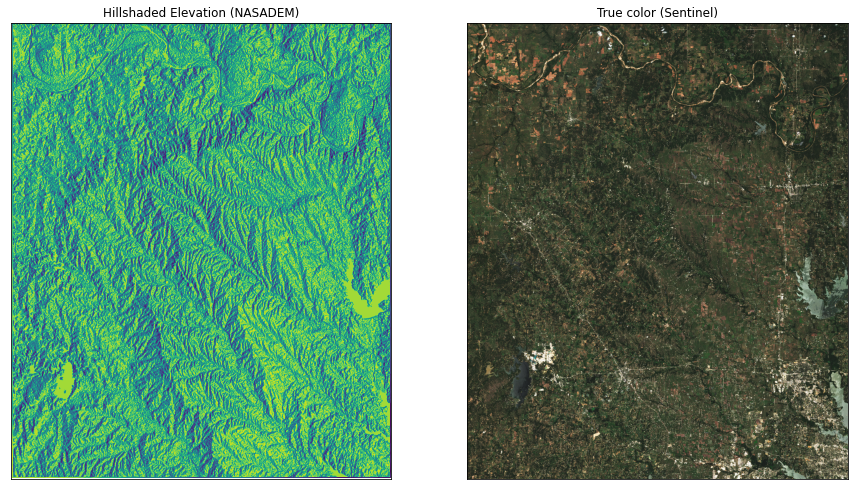

In [10]:
plot_imgs(
    imgs=[[nasadem_data, hillshaded_nasadem_data], sentinel_img],
    titles=[hillshaded_nasadem_data.name, sentinel_img.name]
)

## Zonal Statistics

Zonal statistics requires a zone raster, and a value raster. You'll define your own zone raster by classifying NASADEM elevation data into different categories. Each category represents a single zone. Let's say you want to divide your data based on 5 quantile groups of equal size.

In [11]:
quantile_zones = equal_interval(
    nasadem_data,
    k=5,
    name='Zones (Classified Elevation - NASADEM)'
)

Now let's create a value raster of NDVI using Sentinel data.

In [12]:
ndvi_values = ndvi(
    sentinel_data.sel(band='nir'),
    sentinel_data.sel(band='red'),
    name='Values (NDVI - Sentinel)'
)

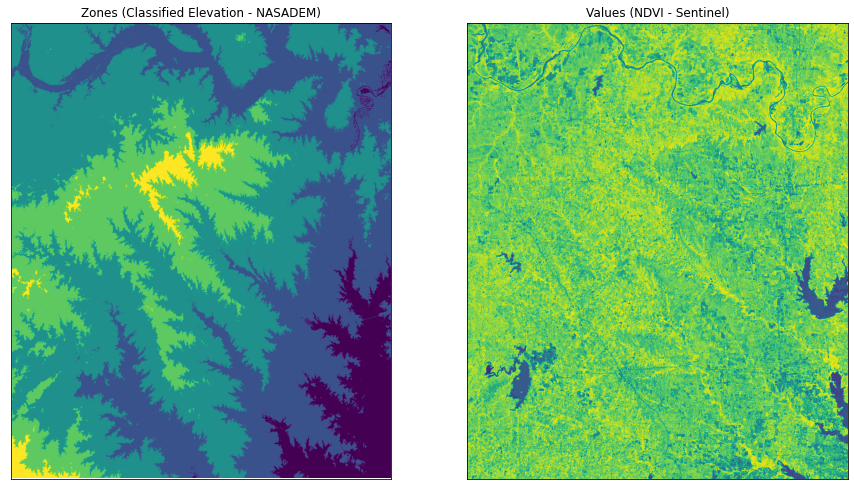

In [13]:
plot_imgs(
    imgs=[quantile_zones, ndvi_values],
    titles=[quantile_zones.name, ndvi_values.name]
)

[xrspatial.zonal_stats](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.stats.html) calculates zonal statistics and returns a DataFrame where each column is a statistic and each row is a zone. By default, seven statistics are computed:

1. Mean
2. Max
3. Min
4. sum
5. Std
6. Var
7. Count

In [14]:
quantile_stats = zonal_stats(
    zones=quantile_zones,
    values=ndvi_values
)

quantile_stats.compute()

,zone,mean,max,min,sum,std,var,count
0,0.0,0.440738,0.900511,-0.419831,48475.463503,0.319417,0.102027,109987
1,1.0,0.585294,0.899222,-0.443129,243549.484564,0.193866,0.037584,416115
2,2.0,0.579834,0.893552,-0.414806,376903.992603,0.176494,0.031150,650021
3,3.0,0.603123,0.888252,-0.351653,168173.520301,0.153788,0.023651,278838
4,4.0,0.614063,0.875973,-0.183576,18970.852654,0.157994,0.024962,30894


## Zonal Crosstab

[xrspatial.crosstab](https://xarray-spatial.org/reference/_autosummary/xrspatial.zonal.crosstab.html) requires a zone raster, and a categorical value raster. It calculates cross tabulation statistics and returns a DataFrame where each column is a category and each row is a zone.

You'll use the same NASADEM elevation zone data as above. For categorical value raster, let's create a new raster by classifying the NDVI values using [xrspatial.classify.equal_interval](https://xarray-spatial.org/reference/_autosummary/xrspatial.classify.equal_interval.html). You'll group your data into 4 classes representing 4 intervals of equal width.

In [15]:
categorical_ndvi = equal_interval(
    ndvi_values,
    k=4,
    name='Values (Classified NDVI - Sentinel)'
)

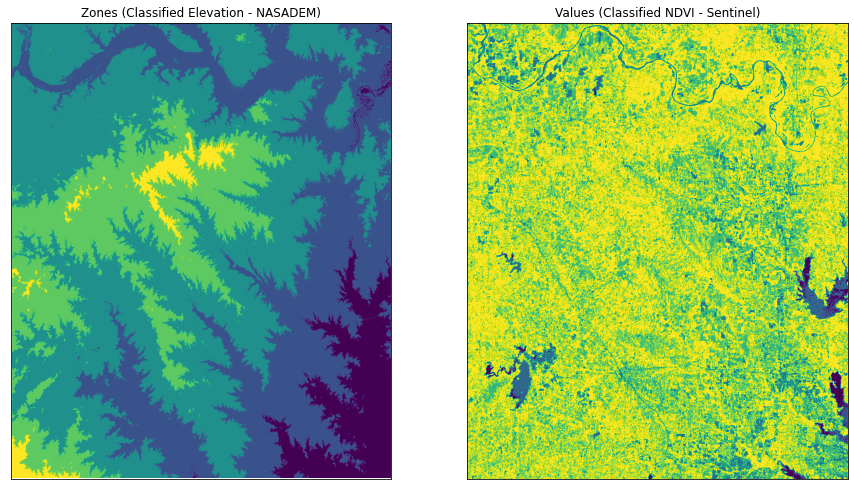

In [16]:
plot_imgs(
    imgs=[quantile_zones, categorical_ndvi],
    titles=[quantile_zones.name, categorical_ndvi.name]
)

Let's calculate cross tabulation statistics. Cell `(i, j)` at row `i`, column `j` of the returning DataFrame shows how many pixels in zone `i` has a value of category `j`.

In [17]:
crosstab_ndvi = zonal_crosstab(
    zones=quantile_zones,
    values=categorical_ndvi
)

crosstab_ndvi.compute()

,zone,0.0,1.0,2.0,3.0
0,0.0,8853,19694,30963,50477
1,1.0,896,26799,132943,255477
2,2.0,2465,29374,224559,393623
3,3.0,90,6324,93496,178928
4,4.0,6,583,10340,19965
